# Some content for introducing Bayesian optimization

First we will do a basic example with direct computation of standard BO tools.  Second, we will compute some stuff 

In [1]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.linalg import cho_solve, cho_factor, solve_triangular
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

### Putting some computations here

In reality, we would not be copying this from the other file, we would just be importing it from a central source.  But we're copying things here to make the notebooks independent.

The most simple (and probably most common) acquisition function which powers Bayesian optimization is called Expected Improvement.  We will consider maximization here, though minimization can be dealt with just as easily.

In [2]:
class GaussianProcess(object):
    def __init__(self, x, y, process_variance, length_scales, observation_noise):
        length_scales = np.array(length_scales)
        x = np.array(x)
        y = np.array(y)
        assert process_variance > 0 and observation_noise >= 0 and all(length_scales > 0)
        assert len(x.shape) == 2 and len(y.shape) == 1 and len(length_scales) == x.shape[1] and x.shape[0] == len(y)
        
        self.x = x
        self.y = y
        self.length_scales = length_scales
        self.process_variance = process_variance
        self.observation_noise = observation_noise
        
        self._distance_matrix_weights = 1 / self.length_scales ** 2
        self._interpolation_weights = None
        self._K_chol = None
        self._initialize()
        
    @property
    def dim(self):
        return self.x.shape[1]
        
    @property
    def num_points(self):
        return self.x.shape[0]
        
    @property
    def max_value(self):
        return np.max(self.y)
        
    def _initialize(self):
        K = self.compute_covariance(self.x, self.x)
        self._K_chol = cho_factor(K + np.eye(self.num_points) * self.observation_noise, lower=True, overwrite_a=True)
        self._interpolation_weights = cho_solve(self._K_chol, self.y)
    
    def _distance_matrix_squared(self, x, z):
        return cdist(x, z, w=self._distance_matrix_weights, metric='sqeuclidean')
    
    def compute_covariance(self, x, z):
        r_squared = self._distance_matrix_squared(x, z)
        return self.process_variance * np.exp(-r_squared)
    
    def posterior_mean(self, x):
        K_eval = self.compute_covariance(x, self.x)
        return np.dot(K_eval, self._interpolation_weights)
    
    def posterior_variance(self, x):
        K_eval = self.compute_covariance(x, self.x)
        symmetric_term = solve_triangular(self._K_chol[0], K_eval.T, lower=self._K_chol[1], overwrite_b=True)
        schur_complement_term = np.sum(symmetric_term ** 2, axis=0)
        return np.fmax(1e-20, self.process_variance - schur_complement_term)

def expected_improvement(gaussian_process, x):
    mean = gaussian_process.posterior_mean(x)
    sqrt_var = np.sqrt(gaussian_process.posterior_variance(x))
    z = (mean - gaussian_process.max_value) / sqrt_var
    return sqrt_var * np.fmax(0.0, z * norm.cdf(z) + norm.pdf(z))

In [3]:
def yf(x):
    x1, x2 = np.array(x).T
    return (
        .75 * np.exp(-.25 * ((9 * x1 - 2) ** 2 + (9 * x2 - 2) ** 2)) +
        .75 * np.exp(-(9 * x1 + 1) ** 2 / 49 - (9 * x2 + 1) / 10) +
        .5 * np.exp(-.25 * ((9 * x1 - 7) ** 2 + (9 * x2 - 3) ** 2)) -
        .2 * np.exp(-(9 * x1 - 4) ** 2 - (9 * x2 - 7) ** 2)
    )

Np = (35, 34)
X0, X1 = np.meshgrid(np.linspace(0, 1, Np[1]), np.linspace(0, 1, Np[0]))
xp = np.array([X0.reshape(-1), X1.reshape(-1)]).T
yp = yf(xp)
Y = yp.reshape(Np)

Now we try and iterate through the optimization process.  At each step during the optimization process, we fit our GP model and optimize our Expected Improvement acquisition function.  Whichever is the best point has maximum EI we evaluate and add to the next GP model.

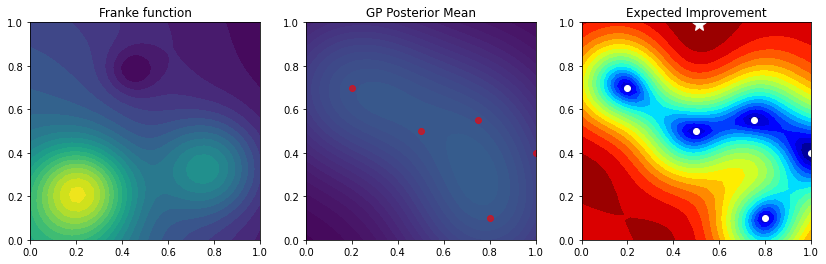

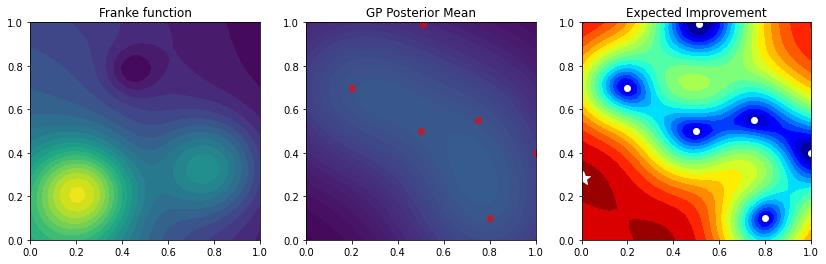

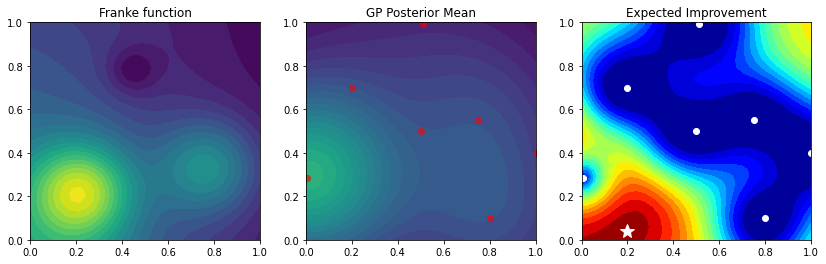

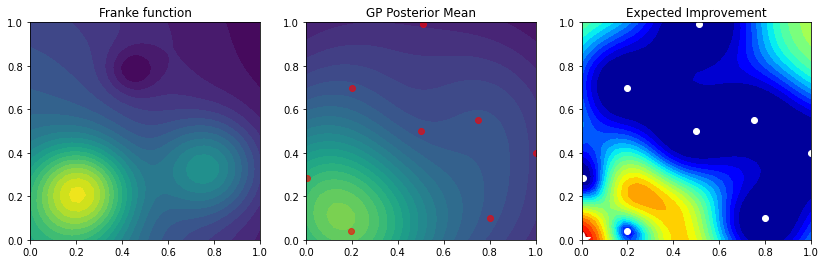

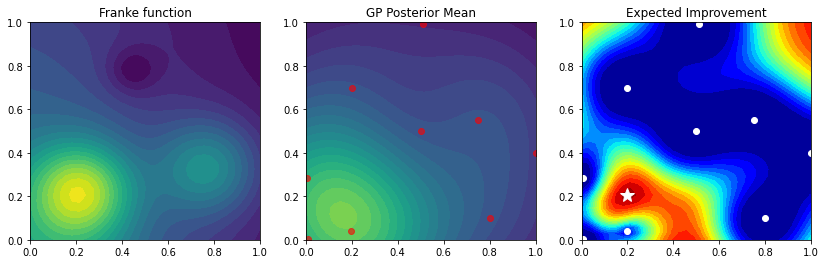

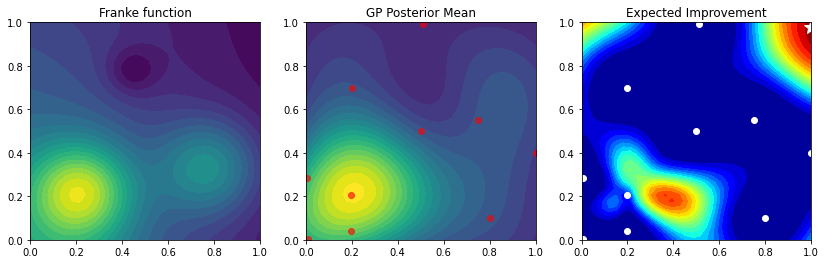

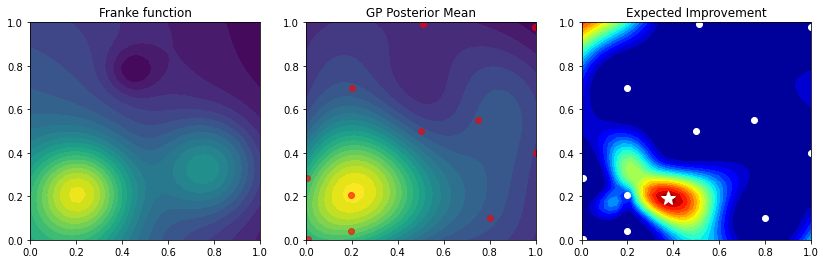

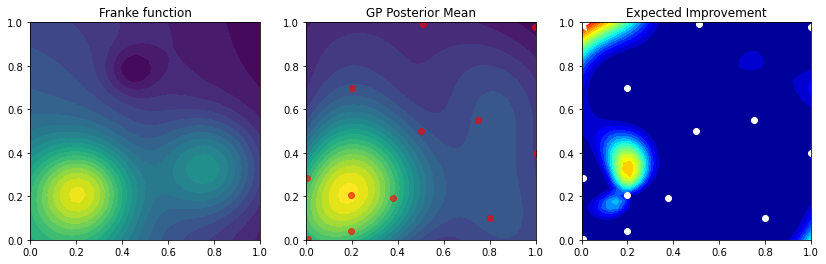

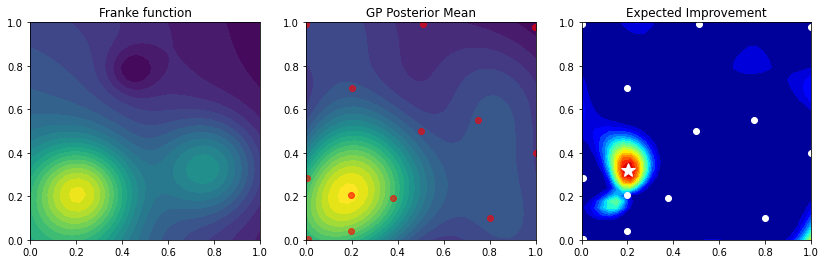

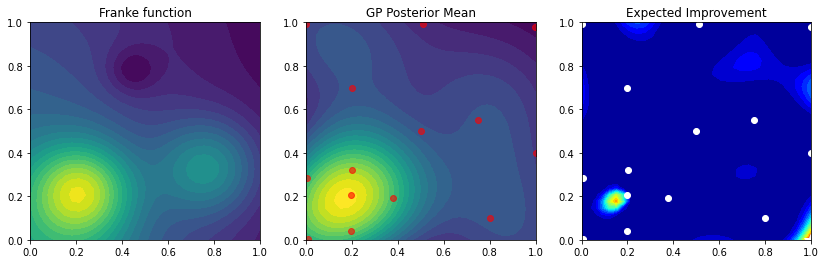

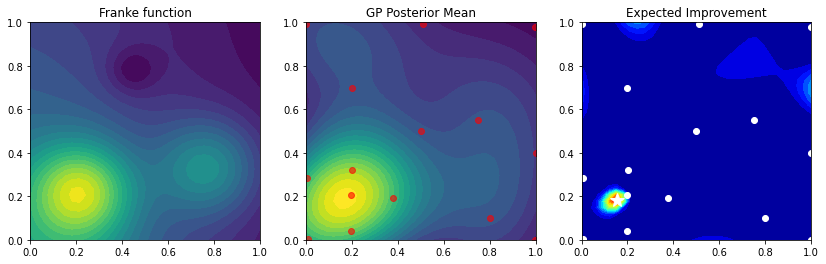

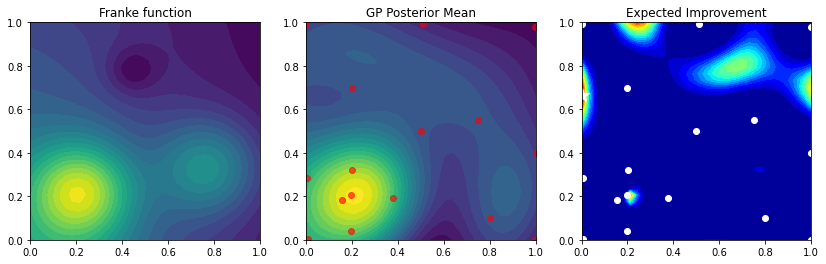

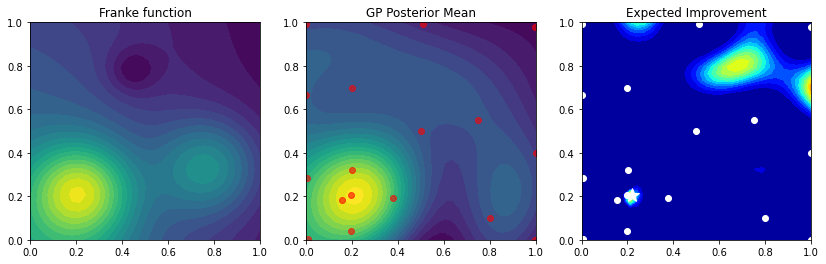

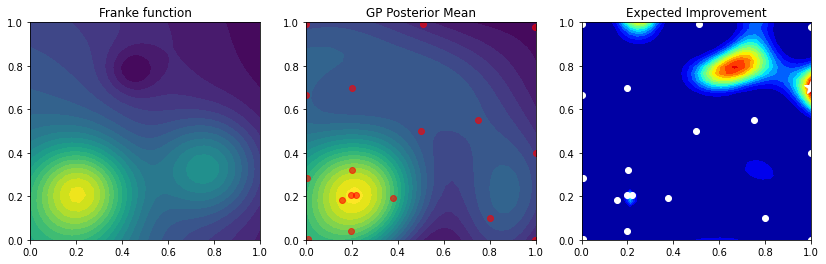

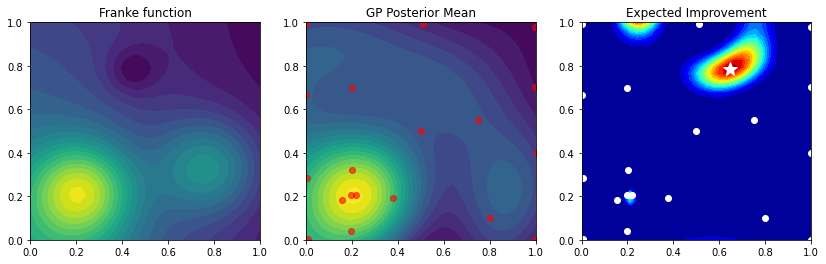

In [4]:
x = np.array([[.2, .7], [.8, .1], [.5, .5], [1, .4], [.75, .55]])
y = yf(x)

process_variance = 1.0
length_scales = [.4] * 2
observation_noise = 1e-5
gaussian_process = GaussianProcess(x, y, process_variance, length_scales, observation_noise)

while gaussian_process.num_points < 20:
    ym = gaussian_process.posterior_mean(xp)
    ei = expected_improvement(gaussian_process, xp)
    YM = ym.reshape(Np)
    EI = ei.reshape(Np)
    
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    ax = axes[0]
    ax.contourf(X0, X1, Y, 20)
    ax.set_title('Franke function')

    ax = axes[1]
    ax.contourf(X0, X1, YM, 20, vmin=0.00114, vmax=1.22)
    ax.plot(x[:, 0], x[:, 1], 'or', alpha=.6)
    ax.set_title('GP Posterior Mean')

    ax = axes[2]
    h = ax.contourf(X0, X1, EI, 20, cmap='jet')
    ax.plot(x[:, 0], x[:, 1], 'ow')
    ax.set_title('Expected Improvement')
    
    xt = np.random.random((20000, 2))
    ei = expected_improvement(gaussian_process, xt)
    next_point = xt[np.argmax(ei)]
    ax.plot(next_point[0], next_point[1], 'w*', markersize=14)
    
    next_value = yf(next_point[None, :])[0]
    x = np.concatenate((x, next_point[None, :]), axis=0)
    y = np.concatenate((y, [next_value]), axis=0)
    gaussian_process = GaussianProcess(x, y, process_variance, length_scales, observation_noise)

### Now we show these same processes using popular tools

First we will show how to use Botorch.

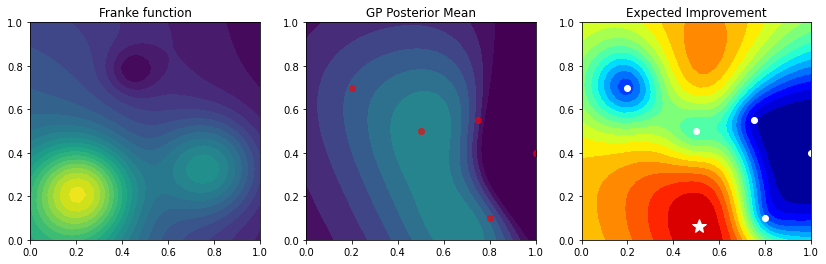

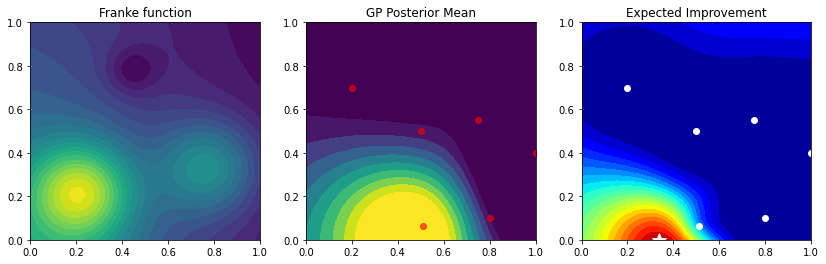

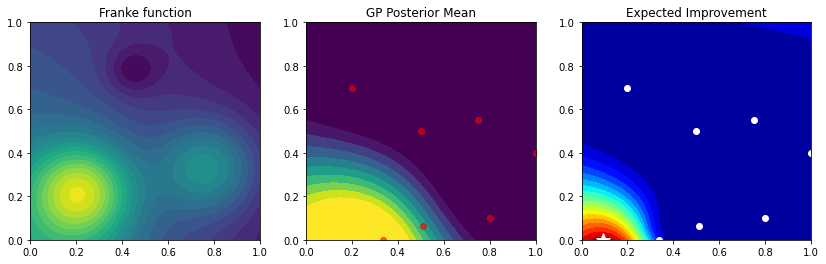

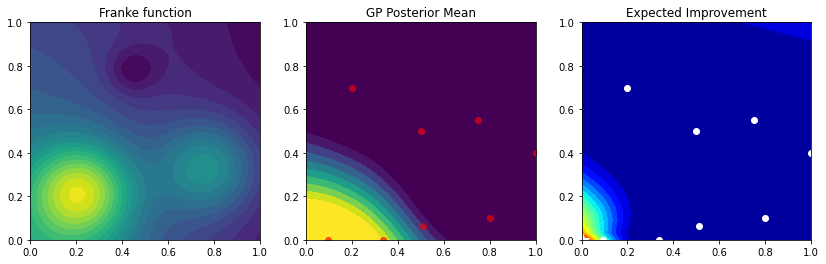

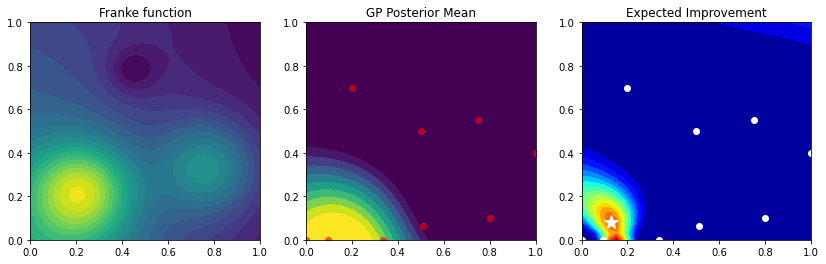

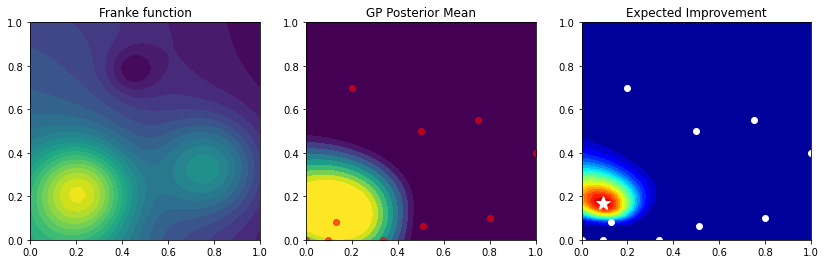

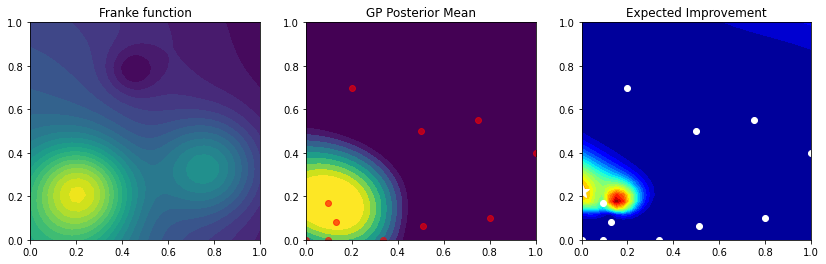

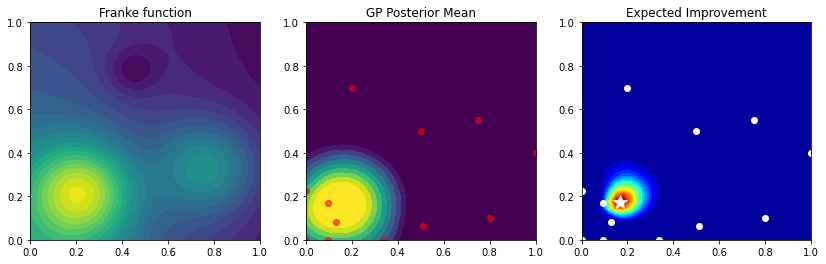

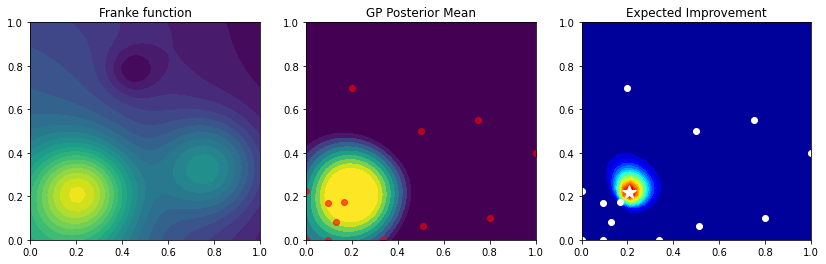

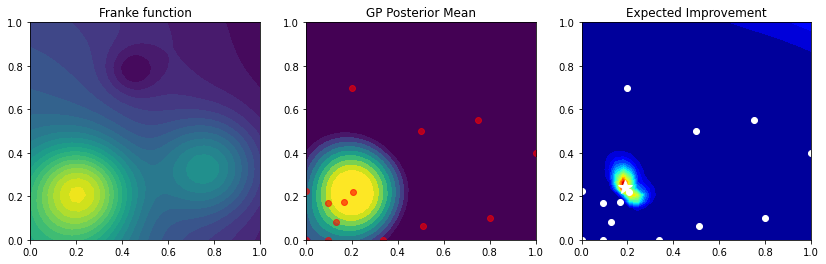

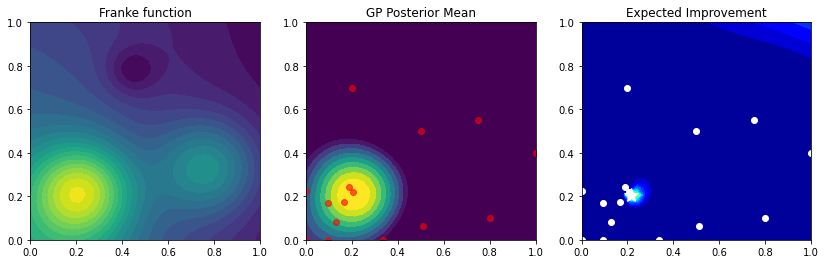

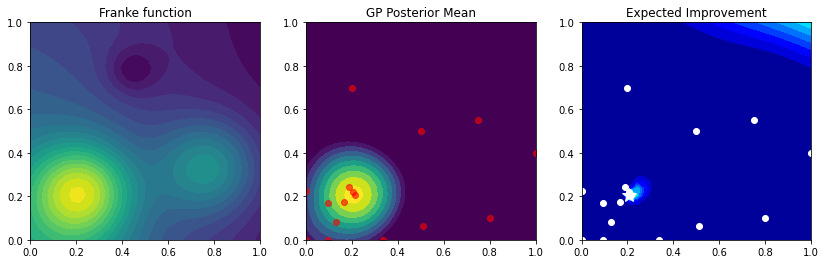

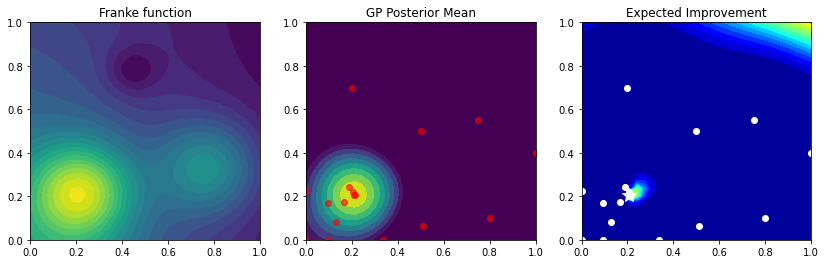

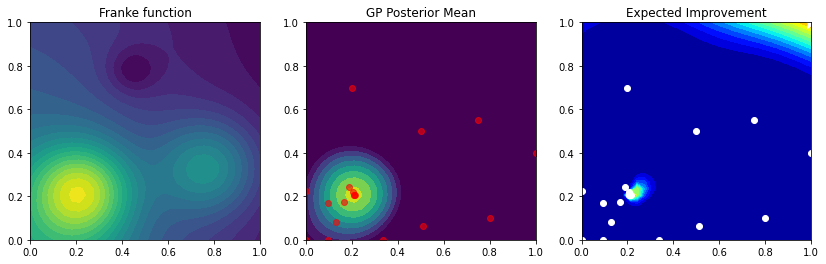

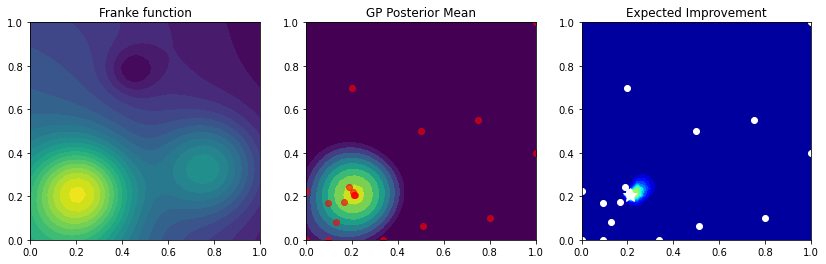

In [5]:
import torch
from botorch.models import SingleTaskGP
from botorch.acquisition import ExpectedImprovement
from botorch.fit import fit_gpytorch_model
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood

bounds = torch.stack([torch.zeros(2), torch.ones(2)])

x = torch.tensor([[.2, .7], [.8, .1], [.5, .5], [1, .4], [.75, .55]], dtype=float)
y = torch.tensor(yf(x), dtype=float)
y_normalized = (y - y.mean()) / y.std()

gp = SingleTaskGP(x, y_normalized[:, None])
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_model(mll)
ei_evaluator = ExpectedImprovement(gp, gp.train_targets.max())

while len(gp.train_targets) < 20:
    ym = gp.posterior(torch.tensor(xp)).mean
    ei = ei_evaluator.forward(torch.tensor(xp[:, None, :]))
    YM = ym.detach().numpy().reshape(Np)
    EI = np.fmax(ei.detach().numpy().reshape(Np), 0)
    
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    ax = axes[0]
    ax.contourf(X0, X1, Y, 20)
    ax.set_title('Franke function')

    ax = axes[1]
    ax.contourf(X0, X1, YM, 20, vmin=0.00114, vmax=1.22)
    ax.plot(x[:, 0], x[:, 1], 'or', alpha=.6)
    ax.set_title('GP Posterior Mean')

    ax = axes[2]
    h = ax.contourf(X0, X1, EI, 20, cmap='jet')
    ax.plot(x[:, 0], x[:, 1], 'ow')
    ax.set_title('Expected Improvement')
    
    next_point, _ = optimize_acqf(
        ei_evaluator, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
    )
    next_point = next_point[0]
    
    ax.plot(next_point[0], next_point[1], 'w*', markersize=14)
    
    next_value = yf(next_point[None, :])[0]
    x = torch.cat((x, next_point[None, :]), axis=0)
    y = torch.cat((y, torch.tensor([next_value])), axis=0)

    y_normalized = (y - y.mean()) / y.std()
    gp = SingleTaskGP(x, y_normalized[:, None])
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll)
    ei_evaluator = ExpectedImprovement(gp, gp.train_targets.max())

### Now we show scikit-optimize

Here we show how to do this with scikit-optimize.  This abstracts out the actual computation behind the scenes, so we do not have access to the underlying models.  We show just the final outcome.

Note that this algorithm only works to minimize, not maximize -- so we need to use a `lambda` to help us actually conduct the minimization.

In [6]:
from skopt import gp_minimize
res = gp_minimize(lambda x: -yf(x),
                  [(0.0, 1.0), (0.0, 1.0)],
                  acq_func="EI",
                  n_calls=20,
                  n_random_starts=5,
                  noise=observation_noise)

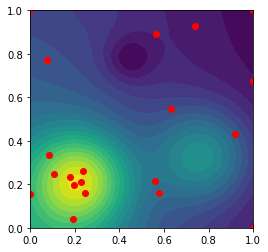

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.contourf(X0, X1, Y, 20)
x_hist = np.array(res.x_iters)
ax.plot(x_hist[:, 0], x_hist[:, 1], 'or');

### Here we show Optuna

Optuna is a really awesome package that has a default that uses an alternative to Gaussian processes to power its optimization process.  It also does not give insights as to the modeling structure during the optimization.

Optuna can be called in many different ways (including in an asynchronous format), but here we are just calling it in its basic sequential structure.  Doing so requires minimization, as well as a structured objective, so we create an additional helper function.

In [8]:
import optuna

def objective(trial):
    x1 = trial.suggest_float('x1', 0, 1)
    x2 = trial.suggest_float('x2', 0, 1)
    return -yf([x1, x2])

study = optuna.create_study()
study.optimize(objective, n_trials=20)

[I 2022-05-25 23:36:24,316] A new study created in memory with name: no-name-889350f7-332e-41fb-beb9-47bd34475481
[I 2022-05-25 23:36:24,319] Trial 0 finished with value: -0.5471470504492719 and parameters: {'x1': 0.8305014546580525, 'x2': 0.3954275167939827}. Best is trial 0 with value: -0.5471470504492719.
[I 2022-05-25 23:36:24,320] Trial 1 finished with value: -0.25771198454202127 and parameters: {'x1': 0.1151508132481126, 'x2': 0.981798262851404}. Best is trial 0 with value: -0.5471470504492719.
[I 2022-05-25 23:36:24,321] Trial 2 finished with value: -1.0539312679323734 and parameters: {'x1': 0.25798671279706453, 'x2': 0.10820068355325896}. Best is trial 2 with value: -1.0539312679323734.
[I 2022-05-25 23:36:24,322] Trial 3 finished with value: -0.43196190863686873 and parameters: {'x1': 0.4606522494060553, 'x2': 0.4218220720770489}. Best is trial 2 with value: -1.0539312679323734.
[I 2022-05-25 23:36:24,323] Trial 4 finished with value: -0.42956548022814234 and parameters: {'x1'

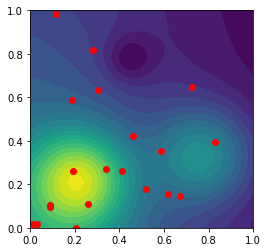

In [9]:
data = study.trials_dataframe()
x1 = np.array(data['params_x1'])
x2 = np.array(data['params_x2'])

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.contourf(X0, X1, Y, 20)
ax.plot(x1, x2, 'or');